# Bitstream Generation


In [1]:
from tensorflow.keras.models import load_model
from qkeras.utils import _add_supported_quantized_objects

co = {}
_add_supported_quantized_objects(co)
import os

os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
os.environ['LD_PRELOAD'] = '/lib/x86_64-linux-gnu/libudev.so.1'

2023-07-08 15:12:49.562805: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

## Load model

In [3]:
model = load_model('LeNet_Prune_Model.h5', custom_objects=co)
model.summary()

2023-07-08 15:12:51.594044: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
/opt/conda/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer LecunUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (QConv2D)             (None, 24, 24, 16)        416       
                                                                 
 relu1 (QActivation)         (None, 24, 24, 16)        0         
                                                                 
 pool1 (MaxPooling2D)        (None, 12, 12, 16)        0         
                                                                 
 conv2 (QConv2D)             (None, 8, 8, 4)           1604      
                                                                 
 relu2 (QActivation)         (None, 8, 8, 4)           0         
                                                                 
 pool2 (MaxPooling2D)        (None, 4, 4, 4)           0         
                                                                 
 flatten (Flatten)           (None, 64)                0

## Convert to hls4ml

In [4]:
import hls4ml
import plotting

config = hls4ml.utils.config_from_keras_model(model, granularity='name')

config['Model']['Precision'] = 'ap_fixed<12,6>'
config['Model']['ReuseFactor'] = 1

for Layer in config['LayerName'].keys():
    config['LayerName'][Layer]['Strategy'] = 'Latency'
    config['LayerName'][Layer]['ReuseFactor'] = 1
    #config['LayerName'][Layer]['Precision'] = 'ap_fixed<8,4>'

config['LayerName']['softmax']['Strategy'] = 'Stable'
'''
for layer in ['conv1', 'conv2'] :
    config['LayerName'][layer]['Precision'] = 'ap_fixed<8,4>'
'''
print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

cfg = hls4ml.converters.create_config(backend='VivadoAccelerator')
cfg['IOType'] = 'io_stream'
cfg['HLSConfig'] = config
cfg['KerasModel'] = model
cfg['OutputDir'] = 'LeNet_PYNQ'
cfg['Board'] = 'pynq-z2'

hls_model = hls4ml.converters.keras_to_hls(cfg)

hls_model.compile()

Interpreting Sequential
Topology:
Layer name: input_1, layer type: InputLayer, input shapes: [[None, 28, 28, 1]], output shape: [None, 28, 28, 1]
Layer name: conv1, layer type: QConv2D, input shapes: [[None, 28, 28, 1]], output shape: [None, 24, 24, 16]
Layer name: relu1, layer type: Activation, input shapes: [[None, 24, 24, 16]], output shape: [None, 24, 24, 16]
Layer name: pool1, layer type: MaxPooling2D, input shapes: [[None, 24, 24, 16]], output shape: [None, 12, 12, 16]
Layer name: conv2, layer type: QConv2D, input shapes: [[None, 12, 12, 16]], output shape: [None, 8, 8, 4]
Layer name: relu2, layer type: Activation, input shapes: [[None, 8, 8, 4]], output shape: [None, 8, 8, 4]
Layer name: pool2, layer type: MaxPooling2D, input shapes: [[None, 8, 8, 4]], output shape: [None, 4, 4, 4]
Layer name: flatten, layer type: Reshape, input shapes: [[None, 4, 4, 4]], output shape: [None, 64]
Layer name: fc1, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 30]
Layer name

Done


## Predict

In [5]:
import numpy as np
y_keras = model.predict(x_test)
x_test = np.ascontiguousarray(x_test)
y_hls = hls_model.predict(x_test)

313/313 [==============================] - 1s 3ms/step


In [6]:
from sklearn.metrics import accuracy_score

print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))

Keras  Accuracy: 0.9529
hls4ml Accuracy: 0.9421


## Synthesize and make bitfile


In [7]:
hls_model.build(csim=False, export=True, bitfile=True)


****** Vivado(TM) HLS - High-Level Synthesis from C, C++ and SystemC v2019.2 (64-bit)
  **** SW Build 2708876 on Wed Nov  6 21:39:14 MST 2019
  **** IP Build 2700528 on Thu Nov  7 00:09:20 MST 2019
    ** Copyright 1986-2019 Xilinx, Inc. All Rights Reserved.

source /opt/Xilinx/Vivado/2019.2/scripts/vivado_hls/hls.tcl -notrace
INFO: Applying HLS Y2K22 patch v1.2 for IP revision
INFO: [HLS 200-10] Running '/opt/Xilinx/Vivado/2019.2/bin/unwrapped/lnx64.o/vivado_hls'
INFO: [HLS 200-10] For user 'jovyan' on host '6307b0c947c6' (Linux_x86_64 version 4.15.0-212-generic) on Sat Jul 08 15:14:55 UTC 2023
INFO: [HLS 200-10] In directory '/home/jovyan/Internship_Waseda/hls4ml/LeNet/LeNet_PYNQ'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-10] Opening project '/home/jovyan/Internship_Waseda/hls4ml/LeNet/LeNet_PYNQ/myproject_prj'.
INFO: [HLS 200-10] Adding design file 'firmware/myproject_axi.cpp' to the project
INFO: [HLS 200-10] Adding design file 'firmware/myproject.cpp' to the project
INFO

{'CSynthesisReport': {'TargetClockPeriod': '5.00',
  'EstimatedClockPeriod': '5.019',
  'BestLatency': '6273',
  'WorstLatency': '6273',
  'IntervalMin': '6274',
  'IntervalMax': '6274',
  'BRAM_18K': '55',
  'DSP': '10',
  'FF': '64307',
  'LUT': '72549',
  'URAM': '0',
  'AvailableBRAM_18K': '280',
  'AvailableDSP': '220',
  'AvailableFF': '106400',
  'AvailableLUT': '53200',
  'AvailableURAM': '0'},
 'TimingReport': {'WNS': 0.142,
  'TNS': 0.0,
  'WHS': 0.015,
  'THS': 0.0,
  'WPWS': 3.75,
  'TPWS': 0.0}}

In [8]:
!sed -n '30,45p' LeNet_PYNQ/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper_utilization_placed.rpt


+----------------------------+-------+-------+-----------+-------+
|          Site Type         |  Used | Fixed | Available | Util% |
+----------------------------+-------+-------+-----------+-------+
| Slice LUTs                 | 39796 |     0 |     53200 | 74.80 |
|   LUT as Logic             | 38718 |     0 |     53200 | 72.78 |
|   LUT as Memory            |  1078 |     0 |     17400 |  6.20 |
|     LUT as Distributed RAM |    22 |     0 |           |       |
|     LUT as Shift Register  |  1056 |     0 |           |       |
| Slice Registers            | 51081 |     0 |    106400 | 48.01 |
|   Register as Flip Flop    | 51081 |     0 |    106400 | 48.01 |
|   Register as Latch        |     0 |     0 |    106400 |  0.00 |
| F7 Muxes                   |    98 |     0 |     26600 |  0.37 |
| F8 Muxes                   |     1 |     0 |     13300 | <0.01 |
+----------------------------+-------+-------+-----------+-------+



## Preparations for deployment

- bitfile: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit` -> `hls4ml_nn.bit`
- hardware handoff: `model_3/hls4ml_prj_pynq/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh` -> `hls4ml_nn.hwh`
- driver: `model_3/hls4ml_prj_pynq/axi_stream_driver.py` -> `axi_stream_driver.py`
- data: `X_test.npy`, `y_test.npy`

In [9]:
!mkdir LeNet_Package_PYNQ
!cp LeNet_PYNQ/myproject_vivado_accelerator/project_1.runs/impl_1/design_1_wrapper.bit LeNet_Package_PYNQ/hls4ml_nn.bit
!cp LeNet_PYNQ/myproject_vivado_accelerator/project_1.srcs/sources_1/bd/design_1/hw_handoff/design_1.hwh LeNet_Package_PYNQ/hls4ml_nn.hwh
!cp LeNet_PYNQ/axi_stream_driver.py LeNet_Package_PYNQ/
!cp X_test.npy y_test.npy LeNet_Package_PYNQ
#!cp part7b_deployment.ipynb model_3/hls4ml_prj_pynq/package
!tar -czvf LeNet_Package_PYNQ.tar.gz -C LeNet_Package_PYNQ/ .

mkdir: cannot create directory ‘LeNet_Package_PYNQ’: File exists
./
./axi_stream_driver.py
./hls4ml_nn.bit
./y_test.npy
./X_test.npy
./hls4ml_nn.hwh


313/313 [==============================] - 1s 2ms/step
Accuracy Keras, CPU:     0.9529
Accuracy hls4ml, CPU: 0.9421
Accuracy hls4ml, pynq-z2: 0.9739


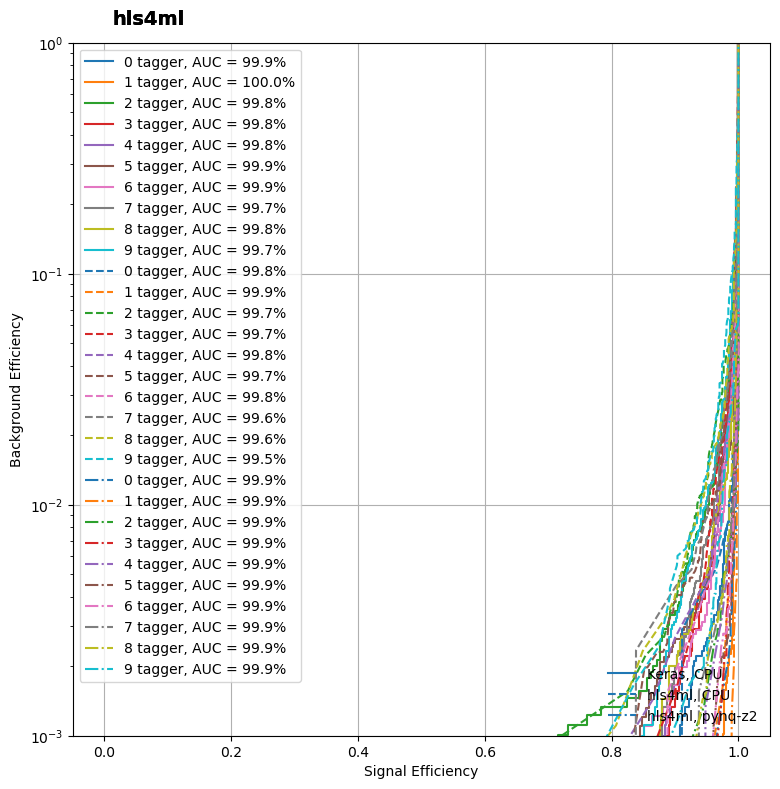

In [10]:
import matplotlib.pyplot as plt

y_hw = np.load('y_hw.npy')
y_test = np.load('y_test.npy')
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
y_hls = hls_model.predict(x_test)
y_qkeras = model.predict(x_test)

print("Accuracy Keras, CPU:     {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_qkeras, axis=1))))
print("Accuracy hls4ml, CPU: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hls, axis=1))))
print("Accuracy hls4ml, pynq-z2: {}".format(accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_hw, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_test, y_qkeras, classes, linestyle='-')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hls, classes, linestyle='--')
plt.gca().set_prop_cycle(None)  # reset the colors
_ = plotting.makeRoc(y_test, y_hw, classes, linestyle='-.')

from matplotlib.lines import Line2D

lines = [Line2D([0], [0], ls='-'), Line2D([0], [0], ls='--'), Line2D([0], [0], ls='-.')]
from matplotlib.legend import Legend

leg = Legend(ax, lines, labels=['Keras, CPU', 'hls4ml, CPU', 'hls4ml, pynq-z2'], loc='lower right', frameon=False)
ax.add_artist(leg)